In [1]:
# Compute the CPRS for the ICPAC region forecasts

import numpy as np
import netCDF4 as nc
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors  # For consistency with Harris et. al 2022
from datetime import datetime, timedelta
from properscoring import crps_ensemble

In [2]:
year = 2020

IMERG_data_dir = "/home/c/cooperf/data/IMERG_6h"
# This is Andrew's quick botch on the data so don't trust it
IFS_data_dir = f"/home/c/cooperf/IFS/IFS-regICPAC-ens-tp"
plot_dir = "/home/c/cooperf/IFS/junk_testing_data/pictures"
save_plots = False

# To be consistent with the Harris et. al paper.
value_range_precip = (0.1, 15)

# Load the constant in time latitude and longitude from a random file
# file_name = IMERG_data_dir + "/3B-HHR.MS.MRG.3IMERG.20210930-S233000-E235959.1410.V06B.HDF5.nc4"
file_name = f"{IMERG_data_dir}/20200101_00.nc4"
nc_file = nc.Dataset(file_name)
latitude = np.array(nc_file["lat"][:])  # Cropping the first point for consistency with the IFS region
longitude = np.array(nc_file["lon"][:])
nc_file.close()

In [3]:
# Load example IMERG rainfall
d = datetime(year,1,13,0)
count = 360  # There is an additional number in the file name
# file_name = f"{IMERG_data_dir}/3B-HHR.MS.MRG.3IMERG.{year}{d.month:02d}{d.day:02d}-S{d.hour:02d}{d.minute:02d}00-E{d.hour:02d}{d.minute+29:02d}59.{count:04d}.V06B.HDF5.nc4"
file_name = f"{IMERG_data_dir}/{year}{d.month:02d}{d.day:02d}_{d.hour:02d}.nc4"
nc_file = nc.Dataset(file_name)
IMERG_rain = np.array(nc_file["precipitationCal"][:,:])
nc_file.close()

In [4]:
# Load example IFS rainfall with a 24 hour lead time
file_name = f"{IFS_data_dir}/{year}/tp_1.nc"
nc_file = nc.Dataset(file_name)
forecast_times = np.array(nc_file["time"][:])
valid_times = np.array(nc_file["valid_time"][:])
tp_IFS_accum = np.array(nc_file["tp"][12,:,4:6,1:,:])*1000/6  # Convert from m/6h to mm/h
tp_IFS = tp_IFS_accum[:,1,:,:] - tp_IFS_accum[:,0,:,:]
nc_file.close()

In [5]:
# Load example cGAN rainfall with a 24 hour lead time
file_name = f"/home/c/cooperf/data/cGAN/ICPAC/GAN_forecasts/GAN_12.nc"
nc_file = nc.Dataset(file_name)
forecast_times_GAN = np.array(nc_file["time"][:])
valid_times_GAN = np.array(nc_file["fcst_valid_time"][:])
tp_GAN = np.array(nc_file["precipitation"][0,:,0,:,:])
nc_file.close()

In [6]:
print(IMERG_rain.shape)
print(tp_IFS.shape)
print(tp_GAN.shape)

(384, 352)
(50, 384, 352)
(50, 384, 352)


In [7]:
IFS_CRPS = crps_ensemble(IMERG_rain, tp_IFS, axis=0)
cGAN_CRPS = crps_ensemble(IMERG_rain, tp_GAN, axis=0)

In [9]:
# Now compare all of the GAN forecasts, IFS forecasts and IMERG data

IFS_CRPS_all = np.zeros((366,4,len(latitude),len(longitude)))
cGAN_CRPS_all = np.zeros((366,4,len(latitude),len(longitude)))
forecast_times = np.zeros((366,4))
valid_times = np.zeros((366,4))
forecast_times_GAN = np.zeros((366,4))
valid_times_GAN = np.zeros((366,4))

for day_num in range(366):   # 0 to 365 (366 days in 2020)
    print(day_num)
    for valid_time_num in range(4):  # There are 4 valid times in each GAN forecast

        # Load example IMERG rainfall
        d = datetime(year,1,2,6*valid_time_num) + timedelta(days=day_num)
        file_name = f"{IMERG_data_dir}/{year}{d.month:02d}{d.day:02d}_{d.hour:02d}.nc4"
        nc_file = nc.Dataset(file_name)
        IMERG_rain = np.array(nc_file["precipitationCal"][:,:])
        nc_file.close()
        
        # Load example IFS rainfall with a 24 hour lead time
        forecast_start_date = d-timedelta(days=1)  # 24 hour lead time
        file_name = f"{IFS_data_dir}/{year}/tp_{forecast_start_date.month}.nc"
        nc_file = nc.Dataset(file_name)
        forecast_time = np.array(nc_file["time"][forecast_start_date.day-1])
        valid_time = np.array(nc_file["valid_time"][forecast_start_date.day-1,4+valid_time_num])
        tp_IFS_accum = np.array(nc_file["tp"][forecast_start_date.day-1,:,4+valid_time_num:6+valid_time_num,1:,:])*1000/6  # Convert from m/6h to mm/h
        tp_IFS = tp_IFS_accum[:,1,:,:] - tp_IFS_accum[:,0,:,:]
        nc_file.close()
        
        # Load the cGAN forecast
        file_name = f"/home/c/cooperf/data/cGAN/ICPAC/GAN_forecasts/GAN_{day_num}.nc"
        nc_file = nc.Dataset(file_name)
        forecast_time_GAN = np.array(nc_file["time"][0])
        valid_time_GAN = np.array(nc_file["fcst_valid_time"][0,valid_time_num])
        tp_GAN = np.array(nc_file["precipitation"][0,:,valid_time_num,:,:])
        nc_file.close()

        # Compute the CRPS
        IFS_CRPS = crps_ensemble(IMERG_rain, tp_IFS, axis=0)
        cGAN_CRPS = crps_ensemble(IMERG_rain, tp_GAN, axis=0)
        
        # Save for later
        IFS_CRPS_all[day_num,valid_time_num,:,:] = IFS_CRPS
        cGAN_CRPS_all[day_num,valid_time_num,:,:] = cGAN_CRPS
        forecast_times[day_num,valid_time_num] = forecast_time
        valid_times[day_num,valid_time_num] = valid_time
        forecast_times_GAN[day_num,valid_time_num] = forecast_time_GAN
        valid_times_GAN[day_num,valid_time_num] = valid_time_GAN

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
# Check the valid times are the same
print(np.max(np.abs(forecast_times - forecast_times_GAN)))
print(np.max(np.abs(valid_times - valid_times_GAN)))

0.0
0.0


In [11]:
# Save the data for later processing
output_data_dir = "/home/c/cooperf/IFS/To_ICPAC/Jan_2024"
file_name = "CRPS_2020.nc"

# Create a new NetCDF file
rootgrp = nc.Dataset(f"{output_data_dir}/{file_name}", "w", format="NETCDF4")

# Describe where this data comes from
rootgrp.description = "IFS and cGAN CRPS vs IMERG rain data for 2020."

# Create dimensions
longitude_dim = rootgrp.createDimension("longitude", len(longitude))
latitude_dim = rootgrp.createDimension("latitude", len(latitude))
time_dim = rootgrp.createDimension("time", None)
valid_time_dim = rootgrp.createDimension("valid_time", 4)
#ensemble_dim = rootgrp.createDimension("member", num_ensemble_members)

# Create the longitude variable
longitude_data = rootgrp.createVariable("longitude", "f4", ("longitude"), zlib=False)
longitude_data.units = "degrees_east"
longitude_data[:] = longitude   # Write the longitude data

# Create the latitude variable
latitude_data = rootgrp.createVariable("latitude", "f4", ("latitude"), zlib=False)
latitude_data.units = "degrees_north"
latitude_data[:] = latitude     # Write the latitude data

# Create the time variable
time_data = rootgrp.createVariable("time", "f4", ("time"), zlib=False)
time_data.units = "hours since 1900-01-01 00:00:00.0"
time_data[:] = forecast_times[:,0]     # Write the forecast_times data

# Create the valid_time variable
valid_time_data = rootgrp.createVariable("valid_time", "f4", ("time","valid_time"), zlib=False)
valid_time_data.units = "hours since 1900-01-01 00:00:00.0"
valid_time_data[:] = valid_times     # Write the valid_times data

# Create the IFS_CRPS variable
IFS_CRPS_data = rootgrp.createVariable("IFS_CRPS", "f4", ("time","valid_time","latitude","longitude"), zlib=True)
IFS_CRPS_data.description = "IFS vs IMERG CPRS"
IFS_CRPS_data.units = "mm/h"
IFS_CRPS_data[:] = IFS_CRPS_all     # Write the IMERG_rain_all data

# Create the IFS_CRPS variable
cGAN_CRPS_data = rootgrp.createVariable("cGAN_CRPS", "f4", ("time","valid_time","latitude","longitude"), zlib=True)
cGAN_CRPS_data.description = "cGAN vs IMERG CPRS"
cGAN_CRPS_data.units = "mm/h"
cGAN_CRPS_data[:] = cGAN_CRPS_all     # Write the IMERG_rain_all data

# Close the NetCDF file
rootgrp.close()

In [12]:
IFS_CRPS_all.shape

(366, 4, 384, 352)

In [13]:
np.mean(IFS_CRPS_all[:,:,:,:])

0.08864993280075292

In [14]:
np.mean(cGAN_CRPS_all[:,:,:,:])

0.07591930233014502

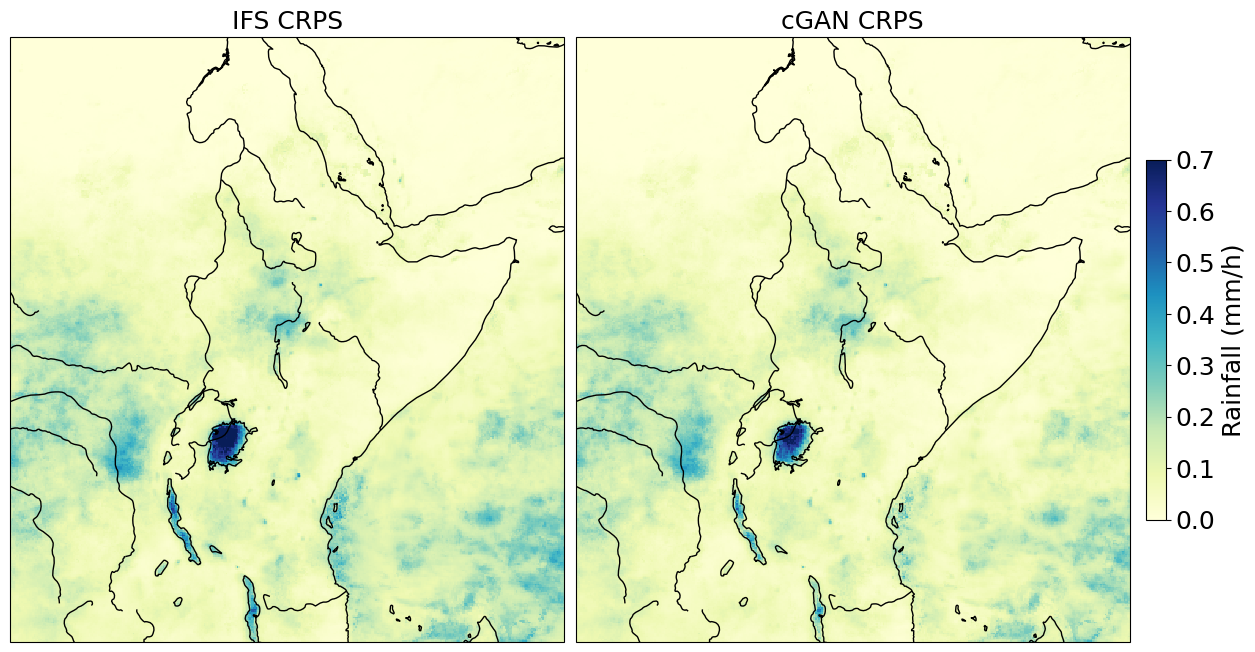

In [15]:
# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8))

# axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, np.mean(IFS_CRPS_all[:,0,:,:], axis=0), 
                  # norm=colors.LogNorm(*value_range_precip),
                  vmin=0, vmax=0.7,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IFS CRPS",size=18)

ax=axs[1]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, np.mean(cGAN_CRPS_all[:,0,:,:], axis=0), 
                  # norm=colors.LogNorm(*value_range_precip),
                  vmin=0, vmax=0.7,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title("cGAN CRPS",size=18)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])

# Draw the colorbar
cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
cb.ax.tick_params(labelsize=18)
cb.set_label('Rainfall (mm/h)',size=18)

# Save the picture
# plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

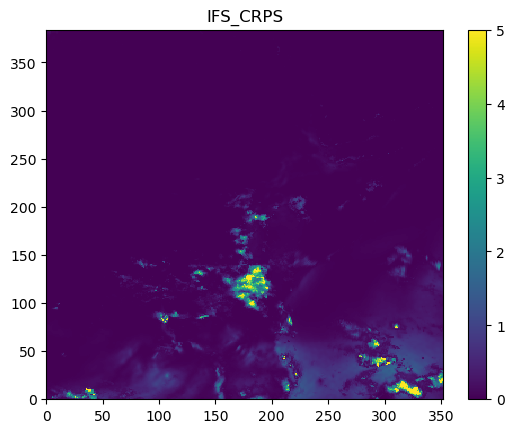

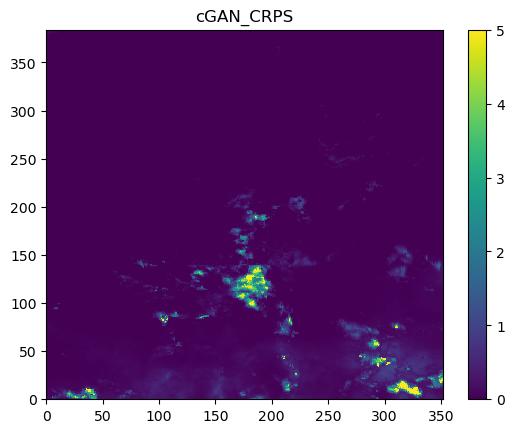

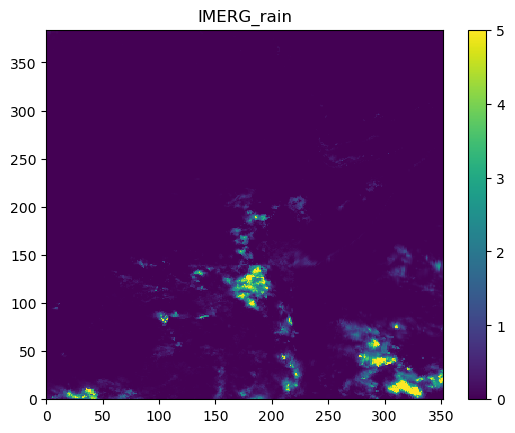

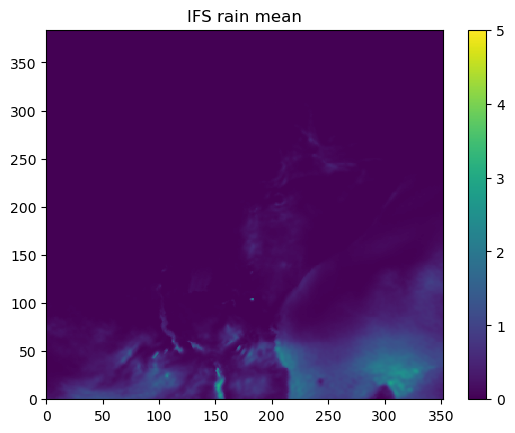

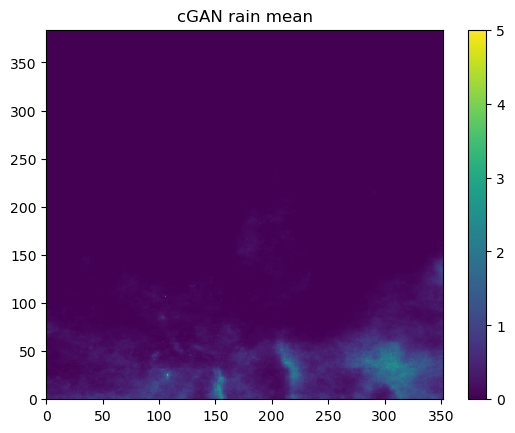

In [8]:
# So this is a case study
# Keep that for reporting

plt.pcolormesh(IFS_CRPS,vmin=0,vmax=5)
plt.colorbar()
plt.title("IFS_CRPS")
plt.show()

plt.pcolormesh(cGAN_CRPS,vmin=0,vmax=5)
plt.colorbar()
plt.title("cGAN_CRPS")
plt.show()

plt.pcolormesh(IMERG_rain,vmin=0,vmax=5)
plt.colorbar()
plt.title("IMERG_rain")
plt.show()

plt.pcolormesh(np.mean(tp_IFS,axis=0),vmin=0,vmax=5)
plt.colorbar()
plt.title("IFS rain mean")
plt.show()

plt.pcolormesh(np.mean(tp_GAN,axis=0),vmin=0,vmax=5)
plt.colorbar()
plt.title("cGAN rain mean")
plt.show()